https://en.lottolyzer.com/history/hong-kong/mark-six/page/1/per-page/50/detail-view

https://is.hkjc.com/aosbs/help/en/mk6_guide.html

Is mark six really a 'fair' game?

In [37]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats

import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv('Data/Mark_Six.csv')

In [39]:
df.columns

Index(['Draw', 'Date', 'Winning Number 1', '2', '3', '4', '5', '6',
       'Extra Number', 'From Last', 'Low', 'High', 'Odd', 'Even', '1-10',
       '11-20', '21-30', '31-40', '41-50', 'Division 1 Winners',
       'Division 1 Prize', 'Division 2 Winners', 'Division 2 Prize',
       'Division 3 Winners', 'Division 3 Prize', 'Division 4 Winners',
       'Division 4 Prize', 'Division 5 Winners', 'Division 5 Prize',
       'Division 6 Winners', 'Division 6 Prize', 'Division 7 Winners',
       'Division 7 Prize', 'Turnover'],
      dtype='object')

In [40]:
df['HKJC profit'] = df['Turnover'].astype(float)  # Ensure float type for calculations
for i in range(1, 7):
    prize_col = f'Division {i} Prize'
    winners_col = f'Division {i} Winners'
    
    if prize_col in df.columns and winners_col in df.columns:
        total_payout = df[prize_col] * df[winners_col]

        condition = df[winners_col] >= 1
        df.loc[condition, 'HKJC profit'] = df.loc[condition, 'HKJC profit'] - total_payout[condition]
        
        half_winners = df[winners_col] == 0.5
        df.loc[half_winners, 'HKJC profit'] = df.loc[half_winners, 'HKJC profit'] - (total_payout[half_winners] / 2)


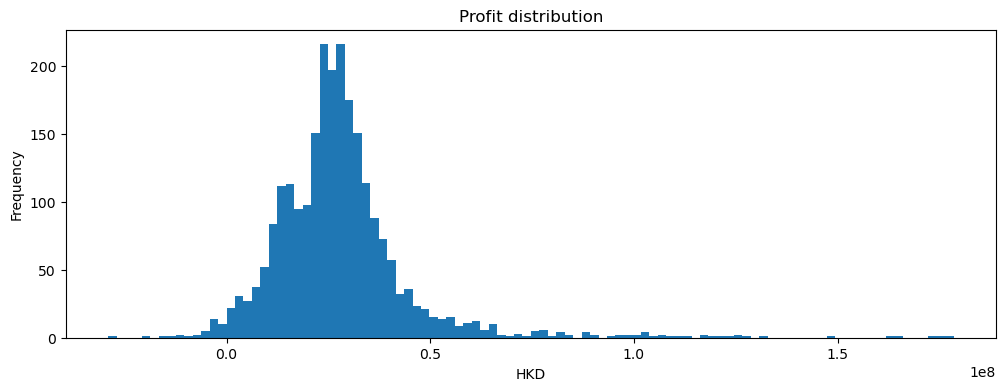

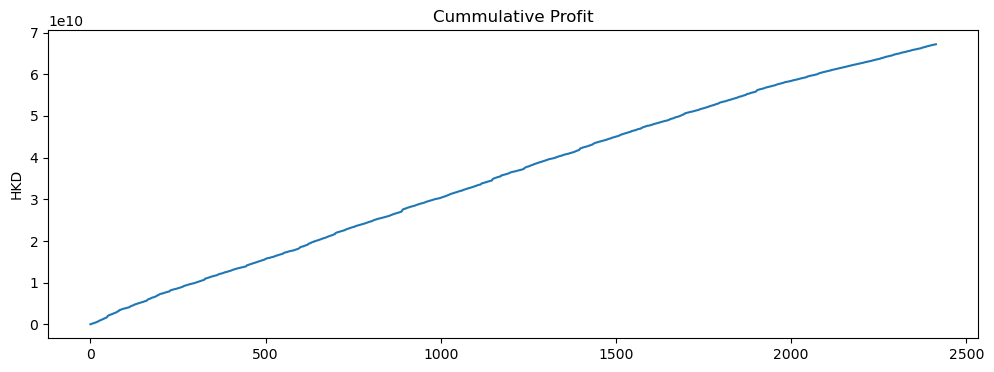

In [45]:
df['HKJC profit'].plot.hist(figsize=(12,4),bins=100)
plt.title('Profit distribution')
plt.xlabel('HKD')
plt.show()

df['HKJC profit'].cumsum().plot(figsize=(12,4))
plt.title('Cummulative Profit')
plt.ylabel('HKD')
plt.show()

(To be fair only 6% goes directly to HKJC and HK tax 25% of it https://en.wikipedia.org/wiki/Mark_Six)

# Betting method
https://special.hkjc.com/e-win/en-US/betting-info/marksix/chance-table/


## Multiple:
You can buy 6+ number to increase your change of hitting the pool. In HKJC website there is acutally a table for how much to ticket would become.

## Banker
you can bet bankers as well.

Let $m$ be the number of banker (number that you must hit) and $n$ be the number of leg (optional number could be hit).

The ticket price formula is actually very simple, you paid Y time as much as you ehanced ($E$) your winning chance.

By buying $m$ muliple you enhanced your probability by $mC6$ times so the price becomes $\$ 10 \times mC6$.

For $m$ banker and $n$ leg the price becomes $\$ 10 \times nC(6-m)$.

# Model
Suppose on average the fraction of bet tpye $i$ is $f_i$.

Consider a general case where the enhancement factor is independent of the cost multiplier:

Define

* $T$ = Total turnover (fixed)
  
* $C_s$ = Cost of a simple bet (e.g., $10)

* $p_b$ = Base probability of winning with a simple bet
* $B_i$ = Bet type $i$
* $f_i$ = Fraction of bets of type $i$ in the distribution
* $E_i$ = Enhancement factor for bet type $i$
* $C_i$ = Cost multiplier for bet type $i$ (relative to simple bet)
* $N$ = Total number of bets placed

With $T$ being fixed, we have

$$
N = \frac{T}{C_s\sum_i f_i C_i}
$$

The expected number of winner is just
$$
W = N \cdot p_b \cdot \sum_i f_i E_i
$$

$$
W = \frac{T p_b}{C_s} \cdot \frac{\sum_i f_i C_i}{\sum_i f_i E_i}
$$

Now, since $C_i = E_i$ for HKJC mark six, the expected number of winner is independent of the betting distribution!!

$$
W = \frac{Tp_b}{C_s} = p_b N_\mathrm{s}
$$
where $N_s = T/C_s$.

So it is valid to tread every bets as simple bet.

In [58]:
ticket_cost = 10
df['bet volume'] = df['Turnover']/ticket_cost

The probability of getting the D1 Price is 
$$
P = 49C6 = \frac{6! 43!}{49!}
$$

In [63]:
P_D1_theoretical = 1/math.comb(49, 6)
P_D1_theoretical

7.151123842018516e-08

Now we compute the imply probability:

In [66]:
df['implied_probability'] = df['Division 1 Winners'] / df['bet volume']

In [68]:
df['expected_winners'] = df['bet volume'] * P_D1_theoretical

total_observed = df['Division 1 Winners'].sum()
total_expected = df['expected_winners'].sum()

print(f"Total observed Division 1 winners: {total_observed}")
print(f"Total expected Division 1 winners: {total_expected}")
print(f"Ratio (observed/expected): {total_observed/total_expected:.4f}")

Total observed Division 1 winners: 1043.2
Total expected Division 1 winners: 895.1074269784442
Ratio (observed/expected): 1.1654


Now we run a chi^2 test and seem if the observed pattern is actually as the theory.

H0: The observed count comes from a Poisson with mean = expected count

$$
\chi^2 = \sum_i^n \frac{(O_i-E_i)^2}{E_i}
$$
We will use 2 bins i = 1,2 where

i=1: $O_1$ = observed winner, $E_1$ = expected winner

i=2: $O_2$ = Total bet volume - observed winner, $E_2$ = Total bet volume - expected winner

In [70]:
observed = np.array([total_observed, df['bet volume'].sum() - total_observed])
expected = np.array([total_expected, df['bet volume'].sum() - total_expected])

chi2_stat, chi2_p_value = stats.chisquare(observed, expected)

print("Chi^2 test results:")
print(f"p-value: {chi2_p_value:.8f}")

Chi^2 test results:
p-value: 0.00000074


So Chi^2 show significant miss-alignment!

What if we tread the winner 'arrival' as Poisson? 

H0: The observed count comes from a Poisson with mean = expected count

We compute the 
$$
P(X \leq \mathrm{observed}), \ \mathrm{where} \ X \sim \mathrm{Poisson}(\mathrm{expected})
$$

In [75]:
poisson_p_value = stats.poisson.cdf(total_observed, total_expected)

if total_observed > total_expected:
    poisson_p_value = 2 * (1 - poisson_p_value)
else:
    poisson_p_value = 2 * poisson_p_value

print("\nPoisson test results:")
print(f"p-value: {poisson_p_value:.8f}")


Poisson test results:
p-value: 0.00000132


It is pretty clear that in this $simple \ estimate$ it is true that the probability is a bit fishy.

HKJC is letting people win more than math suggest!